# Notebook N03 – Haltestellenkarte und mittlere Verspätung (Züge, Schweiz)

Ziel dieses Notebooks:
- Konzentration auf Zugverkehr (PRODUKT_ID = "Zug")
- Aggregation der Verspätung pro Haltestelle (BPUIC + Name)
- Join mit Haltestellen-Koordinaten
- Visualisierung: Punktkarte der Schweiz, eingefärbt nach mittlerer Ankunftsverspätung

In [4]:
# %% setup path for imports
import sys
from pathlib import Path

project_root = Path().resolve().parents[0]
src_path = project_root / "src"

if str(src_path) not in sys.path:
    sys.path.append(str(src_path))

from utils import load_parquet_safely

In [5]:
# %%
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from utils import load_parquet_safely

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 160)

# Pfad zu eurer Monatsdatei mit BPUIC
data_path = Path("../data/processed/istdata_clean.parquet")
df = load_parquet_safely(data_path)

print(f"Datensatz geladen: {df.shape[0]:,} Zeilen × {df.shape[1]} Spalten")
print(df.columns)
df.head(5)

Datensatz geladen: 65,940,915 Zeilen × 13 Spalten
Index(['BETRIEBSTAG', 'BETREIBER_NAME', 'PRODUKT_ID', 'LINIEN_TEXT', 'HALTESTELLEN_NAME', 'ANKUNFTSZEIT', 'ABFAHRTSZEIT', 'delay_arrival_s',
       'delay_departure_s', 'on_time', 'FAELLT_AUS_TF', 'BPUIC', 'Wochentag'],
      dtype='object')


BETRIEBSTAG                          BETREIBER_NAME PRODUKT_ID LINIEN_TEXT HALTESTELLEN_NAME              ANKUNFTSZEIT              ABFAHRTSZEIT  \
0  2025-09-01  DB ZugBus Regionalverkehr Alb-Bodensee        Zug         IR3      Schaffhausen 2025-01-09 05:54:00+00:00 2025-01-09 05:56:00+00:00   
1  2025-09-01  DB ZugBus Regionalverkehr Alb-Bodensee        Zug         RE3      Schaffhausen 2025-01-09 06:14:00+00:00 2025-01-09 06:16:00+00:00   
2  2025-09-01  DB ZugBus Regionalverkehr Alb-Bodensee        Zug         IR3      Schaffhausen 2025-01-09 06:58:00+00:00 2025-01-09 07:00:00+00:00   
3  2025-09-01  DB ZugBus Regionalverkehr Alb-Bodensee        Zug         RE3      Schaffhausen 2025-01-09 06:58:00+00:00 2025-01-09 07:00:00+00:00   
4  2025-09-01  DB ZugBus Regionalverkehr Alb-Bodensee        Zug         IR3      Schaffhausen 2025-01-09 07:58:00+00:00 2025-01-09 08:00:00+00:00   

   delay_arrival_s  delay_departure_s  on_time  FAELLT_AUS_TF    BPUIC Wochentag  
0            114.0               78.0    False          False  8503424    Monday  
1             42.0                1.0     True          False  8503424    Monday  
2             31.0               17.0     True          False  8503424    Monday  
3             18.0               -2.0     True          False  8503424    Monday  
4             83.0               20.0    False          False  8503424    Monday

In [20]:
# Nur Züge
df_trains = df[df["PRODUKT_ID"] == "Zug"].copy()
print(f"Nur Züge: {df_trains.shape[0]:,} Zeilen")

# Verspätungen in Minuten
df_trains["arr_delay_min"] = df_trains["delay_arrival_s"] / 60
df_trains["dep_delay_min"] = df_trains["delay_departure_s"] / 60


# Delta: wie ändert sich die Verspätung an der Station?
df_trains["delta_delay_min"] = df_trains["dep_delay_min"] - df_trains["arr_delay_min"]
df_trains = df_trains[df_trains["delta_delay_min"].between(-60, 60)]


df_trains[["BETRIEBSTAG", "HALTESTELLEN_NAME", "BPUIC", "arr_delay_min", "dep_delay_min", "delta_delay_min"]].head(10)

Nur Züge: 4,615,140 Zeilen


BETRIEBSTAG HALTESTELLEN_NAME    BPUIC  arr_delay_min  dep_delay_min  delta_delay_min
0  2025-09-01      Schaffhausen  8503424       1.900000       1.300000        -0.600000
1  2025-09-01      Schaffhausen  8503424       0.700000       0.016667        -0.683333
2  2025-09-01      Schaffhausen  8503424       0.516667       0.283333        -0.233333
3  2025-09-01      Schaffhausen  8503424       0.300000      -0.033333        -0.333333
4  2025-09-01      Schaffhausen  8503424       1.383333       0.333333        -1.050000
5  2025-09-01      Schaffhausen  8503424       3.700000       2.400000        -1.300000
6  2025-09-01      Schaffhausen  8503424       4.783333       3.116667        -1.666667
7  2025-09-01      Schaffhausen  8503424       0.183333       0.183333         0.000000
8  2025-09-01      Schaffhausen  8503424      -0.016667       0.250000         0.266667
9  2025-09-01      Schaffhausen  8503424       3.066667       2.233333        -0.833333

In [7]:
print(df_trains["delta_delay_min"].describe())
print(df_trains["delta_delay_min"].quantile([0.01, 0.05, 0.95, 0.99]))
print((df_trains["delta_delay_min"].abs() > 60).mean())

count    4.614856e+06
mean     5.129502e-01
std      1.176836e+00
min     -5.983333e+01
25%      1.000000e-01
50%      5.000000e-01
75%      8.333333e-01
max      6.000000e+01
Name: delta_delay_min, dtype: float64
0.01   -1.516667
0.05   -0.833333
0.95    1.983333
0.99    3.583333
Name: delta_delay_min, dtype: float64
0.0


In [25]:
# BPUIC konsistent als String
df_trains["BPUIC"] = df_trains["BPUIC"].astype(str)

agg_station_day = (
    df_trains
    .groupby(["BETRIEBSTAG","BPUIC", "HALTESTELLEN_NAME"])
    .agg(
        mean_delta_delay_min=("delta_delay_min", "mean"),
        n_obs=("delta_delay_min", "size"),
    )
    .reset_index()
)

print("Aggregierte Haltestellen (Kopf):")
print(agg_station_day.head(10))

print("\nVerteilung der Beobachtungszahlen pro Haltestelle:")
print(agg_station_day["n_obs"].describe())

Aggregierte Haltestellen (Kopf):
  BETRIEBSTAG    BPUIC        HALTESTELLEN_NAME  mean_delta_delay_min  n_obs
0  2025-09-01  8014586                 Konstanz              1.352326     86
1  2025-09-01  8500010                Basel SBB              0.159535    846
2  2025-09-01  8500016         Basel St. Johann              0.224242     44
3  2025-09-01  8500020                  Muttenz              0.587524    175
4  2025-09-01  8500021                 Pratteln              0.570617    173
5  2025-09-01  8500022  Frenkendorf-Füllinsdorf              0.638492     84
6  2025-09-01  8500023                  Liestal              0.437902    197
7  2025-09-01  8500024                   Lausen              0.644106     82
8  2025-09-01  8500025                  Itingen              0.481151     84
9  2025-09-01  8500026                  Sissach              0.376389    192

Verteilung der Beobachtungszahlen pro Haltestelle:
count    51170.000000
mean        90.186750
std        108.948417
mi

In [26]:
# Station über den ganzen Monat
agg_stations = (
    df_trains
    .groupby(["BPUIC", "HALTESTELLEN_NAME"])
    .agg(
        mean_arr_delay_min=("arr_delay_min", "mean"),
        mean_dep_delay_min=("dep_delay_min", "mean"),
        mean_delta_delay_min=("delta_delay_min", "mean"),
        n_obs=("delta_delay_min", "size"),
    )
    .reset_index()
)

print("Aggregierte Haltestellen (Monat, Kopf):")
print(agg_stations.head(10))

print("\nVerteilung der Beobachtungszahlen pro Haltestelle (Monat):")
print(agg_stations["n_obs"].describe())

Aggregierte Haltestellen (Monat, Kopf):
     BPUIC     HALTESTELLEN_NAME  mean_arr_delay_min  mean_dep_delay_min  mean_delta_delay_min  n_obs
0  8002301         Lindau-Reutin            3.000000            8.000000              5.000000      1
1  8002307  Kempten (Allgäu) Hbf            1.150000            0.000000             -1.150000      1
2  8002342            Immenstadt            1.000000            0.000000             -1.000000      1
3  8002347           Oberstaufen            2.000000            2.000000              0.000000      1
4  8002349   Röthenbach (Allgäu)            3.000000            3.000000              0.000000      1
5  8002357           Heimenkirch            4.000000            4.000000              0.000000      1
6  8002363               Hergatz            4.000000            3.000000             -1.000000      1
7  8014468    Laufenburg (Baden)           10.000000           -1.000000            -11.000000      1
8  8014586              Konstanz          

In [27]:
MIN_OBS = 3000

agg_filtered = agg_stations[agg_stations["n_obs"] >= MIN_OBS].copy()
print(f"Haltestellen mit mindestens {MIN_OBS} Fahrten: {agg_filtered.shape[0]}")

# Bahnhöfe, die im Mittel am meisten Verspätung ABBauen (delta stark negativ)
best_stations = (
    agg_filtered
    .sort_values("mean_delta_delay_min", ascending=True)  # stärkste Reduktion zuerst
    .head(30)
)

print("Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):")
print(
    best_stations[["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"]]
    .to_string(index=False)
)

# Bahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta stark positiv)
worst_stations = (
    agg_filtered
    .sort_values("mean_delta_delay_min", ascending=False)  # stärkste Verschlechterung zuerst
    .head(30)
)

print("\nBahnhöfe, die im Mittel am meisten zusätzliche Verspätung erzeugen (delta_delay_min > 0):")
print(
    worst_stations[["HALTESTELLEN_NAME", "BPUIC", "mean_arr_delay_min", "mean_dep_delay_min", "mean_delta_delay_min", "n_obs"]]
    .to_string(index=False)
)

Haltestellen mit mindestens 3000 Fahrten: 453
Bahnhöfe, die im Mittel am meisten Verspätung abgebaut haben (delta_delay_min < 0):
            HALTESTELLEN_NAME   BPUIC  mean_arr_delay_min  mean_dep_delay_min  mean_delta_delay_min  n_obs
              Boudry Tuilière 8530713            2.647998            1.882669             -0.765329   3364
          Auvernier Littorail 8504510            2.283254            1.571168             -0.712087   3377
             Areuse Littorail 8595245            2.323402            1.626045             -0.697357   3380
       Colombier NE Littorail 8504325            2.300089            1.630823             -0.669266   3379
                     Aesch BL 8500117            1.392066            0.912333             -0.479733   4384
                   Schöftland 8502199            0.990898            0.583122             -0.407776   3468
  Neuchâtel Port-de-Serrières 8504509            1.720128            1.334336             -0.385793   3375
         Matte

In [28]:
from pathlib import Path

export_cols = [
    "BPUIC",
    "HALTESTELLEN_NAME",
    "mean_arr_delay_min",
    "mean_dep_delay_min",
    "mean_delta_delay_min",
    "n_obs",
]

out_path = Path("../data/processed/station_delta_delays_2025-09_minObs200.csv")
agg_filtered[export_cols].to_csv(out_path, index=False)

print("Aggregierte Stationskennzahlen gespeichert unter:")
print(out_path)

Aggregierte Stationskennzahlen gespeichert unter:
../data/processed/station_delta_delays_2025-09_minObs200.csv


In [12]:
from pathlib import Path
import pandas as pd

stops_path = Path("../data/external/dienststellen.csv")

# Wichtig: sep=';' setzen, damit das Komma in der Geoposition nicht als Spaltentrenner verwendet wird
stops = pd.read_csv(stops_path, sep=";", dtype=str)

print(stops.columns)
stops.head()

Index(['lod', 'Geoposition', '﻿numberShort', 'uicCountryCode', 'sloid', 'number', 'validFrom', 'validTo', 'designationOfficial', 'designationLong',
       'abbreviation', 'operatingPoint', 'operatingPointWithTimetable', 'stopPoint', 'stopPointType', 'freightServicePoint', 'trafficPoint', 'borderPoint',
       'hasGeolocation', 'isoCountryCode', 'cantonName', 'cantonFsoNumber', 'cantonAbbreviation', 'districtName', 'districtFsoNumber', 'municipalityName',
       'fsoNumber', 'localityName', 'operatingPointType', 'operatingPointTechnicalTimetableType', 'meansOfTransport', 'categories',
       'operatingPointTrafficPointType', 'operatingPointRouteNetwork', 'operatingPointKilometer', 'operatingPointKilometerMasterNumber',
       'sortCodeOfDestinationStation', 'businessOrganisation', 'businessOrganisationNumber', 'businessOrganisationAbbreviationDe',
       'businessOrganisationAbbreviationFr', 'businessOrganisationDescriptionDe', 'businessOrganisationDescriptionFr', 'fotComment', 'height'

lod                             Geoposition ﻿numberShort uicCountryCode               sloid   number  \
0  http://lod.opentransportdata.swiss/didok/1110530    48.469860010403906, 8.49968000801024        10530             11  ch:1:sloid:1110530  1110530   
1  http://lod.opentransportdata.swiss/didok/1110577  52.281669008914854, 10.576396007454766        10577             11  ch:1:sloid:1110577  1110577   
2  http://lod.opentransportdata.swiss/didok/1110609  53.698358007861174, 10.741624006255964        10609             11  ch:1:sloid:1110609  1110609   
3  http://lod.opentransportdata.swiss/didok/1110611   52.58176120729621, 13.579174008055386        10611             11  ch:1:sloid:1110611  1110611   
4  http://lod.opentransportdata.swiss/didok/1110563    50.37017301038644, 8.468945007169054        10563             11  ch:1:sloid:1110563  1110563   

    validFrom     validTo           designationOfficial designationLong abbreviation operatingPoint operatingPointWithTimetable stopPoint stopPointType  \
0  2022-12-11  9999-12-31     Dornstetten, Hauptstrasse             NaN          NaN           true                        true      true           NaN   
1  2022-12-11  9999-12-31  Braunschweig, Petzvalstrasse             NaN          NaN           true                        true      true           NaN   
2  2022-12-11  9999-12-31            Ratzeburg, Bahnhof             NaN          NaN           true                        true      true           NaN   
3  2022-12-11  9999-12-31    Ahrensfelde, Kirschenallee             NaN          NaN           true                        true      true           NaN   
4  2022-12-11  9999-12-31          Hundstadt, Ortsmitte             NaN          NaN           true                        true      true           NaN   

  freightServicePoint trafficPoint borderPoint hasGeolocation isoCountryCode cantonName cantonFsoNumber cantonAbbreviation districtName districtFsoNumber  \
0               false         true       false           true             DE        NaN             NaN                NaN          NaN               NaN   
1               false         true       false           true             DE        NaN             NaN                NaN          NaN               NaN   
2               false         true       false           true             DE        NaN             NaN                NaN          NaN               NaN   
3               false         true       false           true             DE        NaN             NaN                NaN          NaN               NaN   
4               false         true       false           true             DE        NaN             NaN                NaN          NaN               NaN   

  municipalityName fsoNumber localityName operatingPointType operatingPointTechnicalTimetableType meansOfTransport categories operatingPointTrafficPointType  \
0              NaN       NaN          NaN                NaN                                  NaN              BUS        NaN                            NaN   
1              NaN       NaN          NaN                NaN                                  NaN              BUS        NaN                            NaN   
2              NaN       NaN          NaN                NaN                                  NaN              BUS        NaN                            NaN   
3              NaN       NaN          NaN                NaN                                  NaN              BUS        NaN                            NaN   
4              NaN       NaN          NaN                NaN                                  NaN              BUS        NaN                            NaN   

  operatingPointRouteNetwork operatingPointKilometer operatingPointKilometerMasterNumber sortCodeOfDestinationStation businessOrganisation  \
0                      false                   false                                 NaN                          NaN    ch:1:sboid:101257   
1               

In [13]:
# BPUIC
stops["BPUIC"] = stops["operatingPointKilometerMasterNumber"].astype(str)

# Geoposition in lat / lon aufspalten
coords = stops["Geoposition"].str.split(",", n=1, expand=True)
stops["lat"] = coords[0].astype(float)
stops["lon"] = coords[1].astype(float)

stops[["BPUIC", "lat", "lon"]].head()

BPUIC        lat        lon
0   nan  48.469860   8.499680
1   nan  52.281669  10.576396
2   nan  53.698358  10.741624
3   nan  52.581761  13.579174
4   nan  50.370173   8.468945

In [14]:
# BPUIC-Typ harmonisieren
agg_filtered["BPUIC"] = agg_filtered["BPUIC"].astype(str)
stops["BPUIC"] = stops["BPUIC"].astype(str)

stops_small = stops[["BPUIC", "lat", "lon"]].dropna()

stations_geo = agg_filtered.merge(stops_small, on="BPUIC", how="inner")

print("Nach Join:", stations_geo.shape)
stations_geo.head()

Nach Join: (264, 8)


BPUIC HALTESTELLEN_NAME  mean_arr_delay_min  mean_dep_delay_min  mean_delta_delay_min  n_obs        lat       lon
0  8500010         Basel SBB            1.256802            1.422848              0.166046  24382  47.546337  7.588770
1  8500010         Basel SBB            1.256802            1.422848              0.166046  24382  47.544896  7.603332
2  8500010         Basel SBB            1.256802            1.422848              0.166046  24382  47.544936  7.595620
3  8500010         Basel SBB            1.256802            1.422848              0.166046  24382  47.546190  7.579567
4  8500010         Basel SBB            1.256802            1.422848              0.166046  24382  47.547412  7.589563

In [15]:
import json
import matplotlib.pyplot as plt
from pathlib import Path

def plot_switzerland_border(ax, json_path, **plot_kwargs):
    """
    Zeichnet die Schweiz-Grenze aus einer Datei, deren Struktur
    wie folgt ist:
        {"feature": {"geometry": {...}}}
    und geometry.type = MultiPolygon.
    """
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    feat = data["feature"]
    geom = feat["geometry"]
    gtype = geom.get("type", "")
    coords = geom.get("coordinates", [])

    print("Geometry type:", gtype)

    if gtype == "Polygon":
        for ring in coords:
            xs = [pt[0] for pt in ring]
            ys = [pt[1] for pt in ring]
            ax.plot(xs, ys, **plot_kwargs)

    elif gtype == "MultiPolygon":
        for poly in coords:
            for ring in poly:
                xs = [pt[0] for pt in ring]
                ys = [pt[1] for pt in ring]
                ax.plot(xs, ys, **plot_kwargs)

    else:
        print("Geometrietyp nicht unterstützt:", gtype)

Geometry type: MultiPolygon


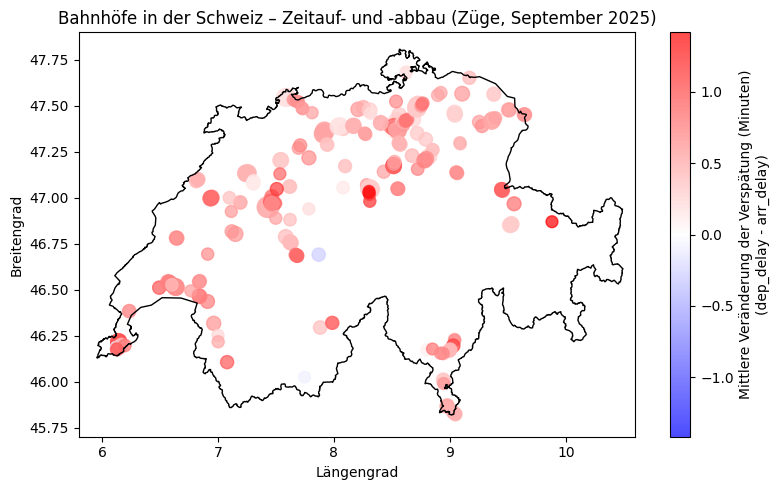

In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

border_path = Path("../data/external/switzerland.geojson")

fig, ax = plt.subplots(figsize=(8, 5))

# 1) Schweiz-Grenze
plot_switzerland_border(
    ax,
    border_path,
    linewidth=1.0,
    color="black",
)

# 2) Farbbereich symmetrisch um 0 wählen,
#    damit blau = Zeit gutmachen, rot = Verspätung
vals = stations_geo["mean_delta_delay_min"]
max_abs = np.nanmax(np.abs(vals))

# 3) Stationen mit blau–weiß–rot einfärben
sc = ax.scatter(
    stations_geo["lon"],
    stations_geo["lat"],
    c=vals,
    cmap="bwr",          # blau–weiß–rot
    vmin=-max_abs,       # symmetrisch um 0
    vmax= max_abs,
    s=stations_geo["n_obs"] ** 0.5,
    alpha=0.7,
)

cb = plt.colorbar(
    sc,
    ax=ax,
    label="Mittlere Veränderung der Verspätung (Minuten)\n(dep_delay - arr_delay)",
)

ax.set_xlabel("Längengrad")
ax.set_ylabel("Breitengrad")
ax.set_title("Bahnhöfe in der Schweiz – Zeitauf- und -abbau (Züge, September 2025)")

# Feste, sinnvolle Schweiz-Bounding-Box
ax.set_xlim(5.8, 10.6)
ax.set_ylim(45.7, 47.9)

plt.tight_layout()
plt.show()

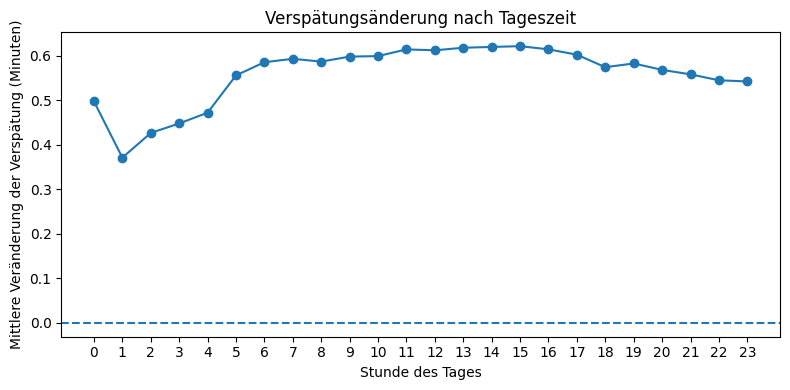

In [29]:
df_trains["hour"] = df_trains["ANKUNFTSZEIT"].dt.hour

hourly = (
    df_trains
    .groupby("hour")["delta_delay_min"]
    .agg(["mean", "median", "size"])
    .reset_index()
)

plt.figure(figsize=(8, 4))
plt.plot(hourly["hour"], hourly["mean"], marker="o")
plt.axhline(0, linestyle="--")
plt.xlabel("Stunde des Tages")
plt.ylabel("Mittlere Veränderung der Verspätung (Minuten)")
plt.title("Verspätungsänderung nach Tageszeit")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

In [49]:
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

border_path = Path("../data/external/switzerland.geojson")

def plot_delay_map_for_day(day_str,
                           df_trains,
                           stops_small,
                           min_obs,
                           max_abs_min):
    """
    Karte der mittleren Verspätungsänderung pro Bahnhof
    für einen Betriebstag (BETRIEBSTAG).

    day_str: z.B. "2025-09-01"
    min_obs: Mindestanzahl Halte pro Station für diesen Tag
    max_abs_min: Farbskala [-max_abs_min, +max_abs_min]
    """

    # 1) Daten für diesen Tag
    df_day = df_trains[df_trains["BETRIEBSTAG"] == day_str].copy()
    if df_day.empty:
        print(f"Keine Daten für {day_str}")
        return None

    # 2) Aggregation pro Station (nur dieser Tag)
    agg_day = (
        df_day
        .groupby(["BPUIC", "HALTESTELLEN_NAME"])
        .agg(
            mean_delta_delay_min=("delta_delay_min", "mean"),
            n_obs=("delta_delay_min", "size"),
        )
        .reset_index()
    )

    # Mindestanzahl Halte
    agg_day = agg_day[agg_day["n_obs"] >= min_obs].copy()
    if agg_day.empty:
        print(f"Keine Stationen mit n_obs >= {min_obs} für {day_str}")
        return None

    # 3) Koordinaten joinen
    day_geo = agg_day.merge(stops_small, on="BPUIC", how="inner")
    if day_geo.empty:
        print(f"Kein Koordinaten-Match für {day_str}")
        return None

    # 4) Plot
    vals = day_geo["mean_delta_delay_min"]
    max_abs = max_abs_min

    fig, ax = plt.subplots(figsize=(8, 5))

    # Schweiz-Grenze
    plot_switzerland_border(
        ax,
        border_path,
        linewidth=1.0,
        color="black",
    )

    sc = ax.scatter(
        day_geo["lon"],
        day_geo["lat"],
        c=vals,
        cmap="bwr",          # oder deine eigene Blau–Rot-Cmap
        vmin=-max_abs,
        vmax= max_abs,
        s=day_geo["n_obs"] ** 0.5,
        alpha=0.7,
    )

    cb = plt.colorbar(
        sc,
        ax=ax,
        label="Mittlere Veränderung der Verspätung (Minuten)\n(dep_delay - arr_delay)",
    )

    ax.set_xlabel("Längengrad")
    ax.set_ylabel("Breitengrad")
    ax.set_title(f"Bahnhöfe – Zeitauf/-abbau am {day_str}")

    ax.set_xlim(5.8, 10.6)
    ax.set_ylim(45.7, 47.9)

    plt.tight_layout()
    plt.show()

    return fig, day_geo

Plot für 2025-09-01 00:00:00
Geometry type: MultiPolygon


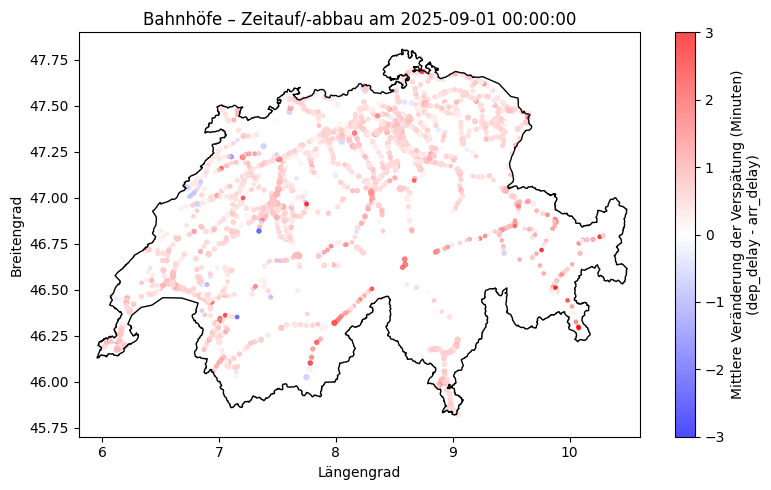

Plot für 2025-09-02 00:00:00
Geometry type: MultiPolygon


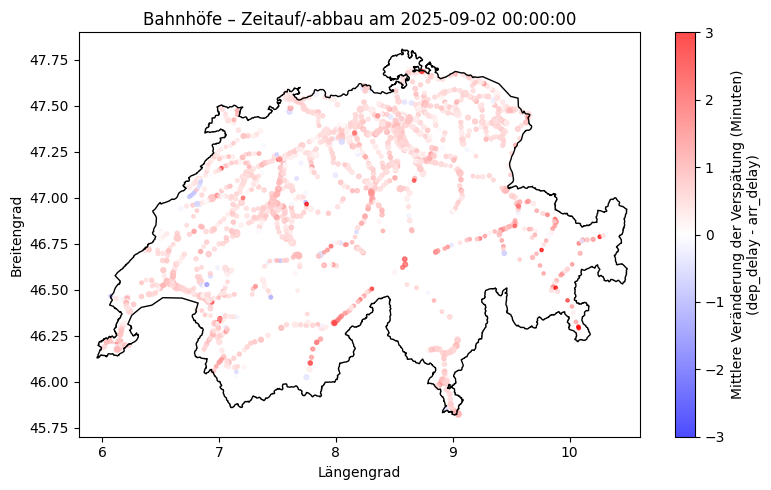

Plot für 2025-09-03 00:00:00
Geometry type: MultiPolygon


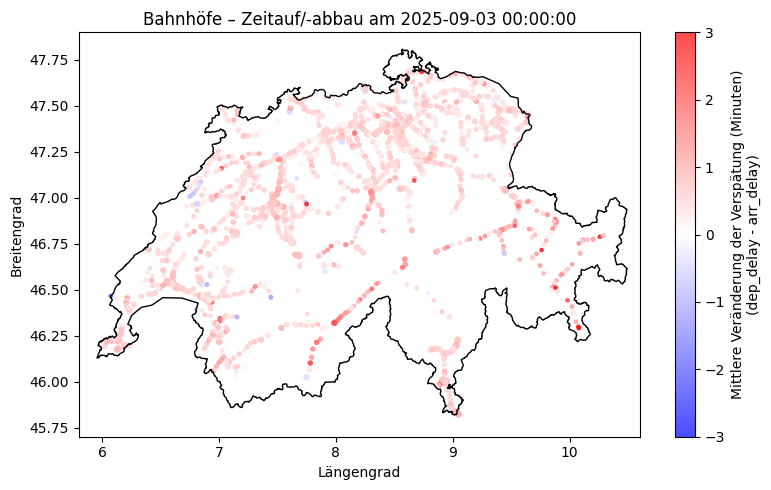

Plot für 2025-09-04 00:00:00
Geometry type: MultiPolygon


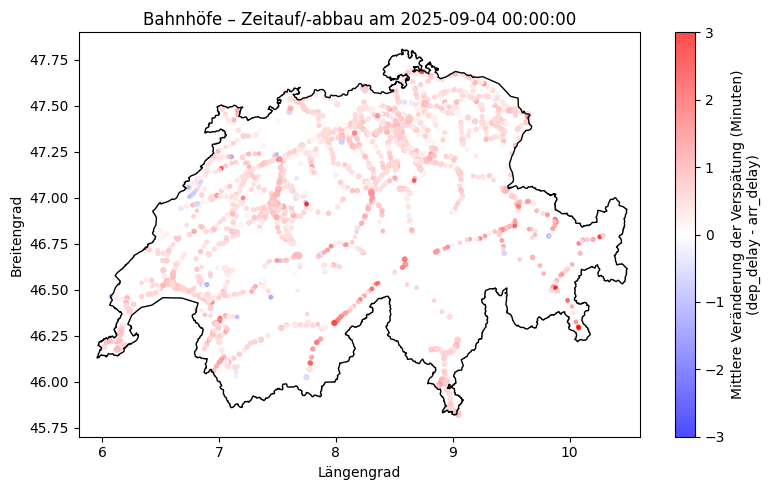

Plot für 2025-09-05 00:00:00
Geometry type: MultiPolygon


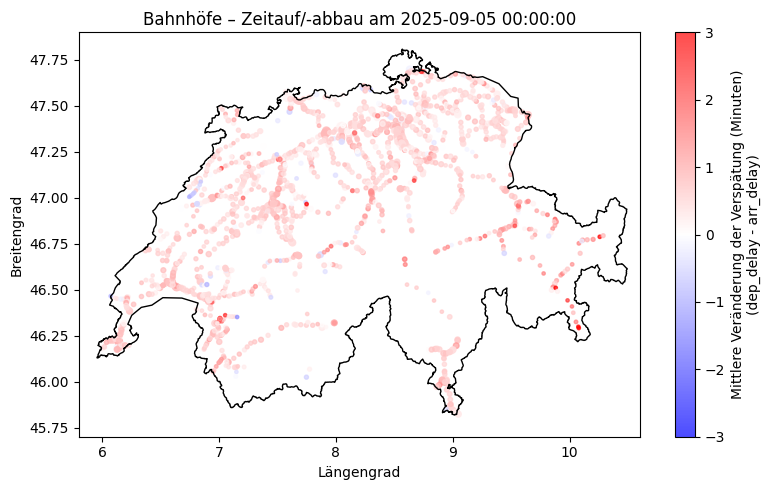

Plot für 2025-09-06 00:00:00
Geometry type: MultiPolygon


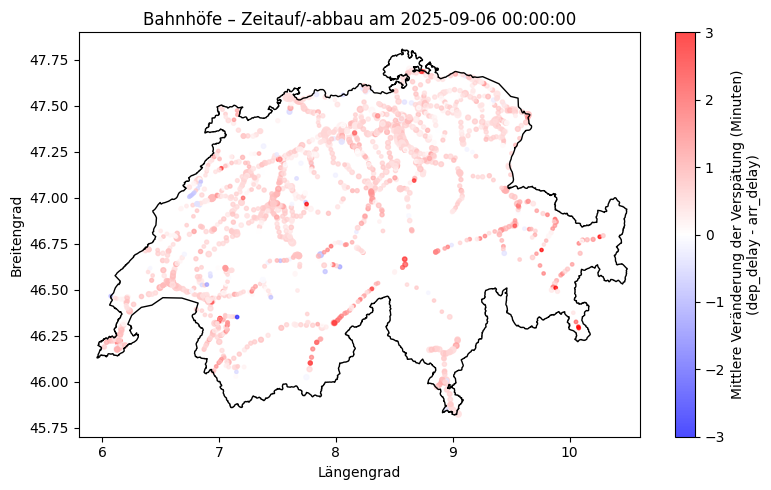

Plot für 2025-09-07 00:00:00
Geometry type: MultiPolygon


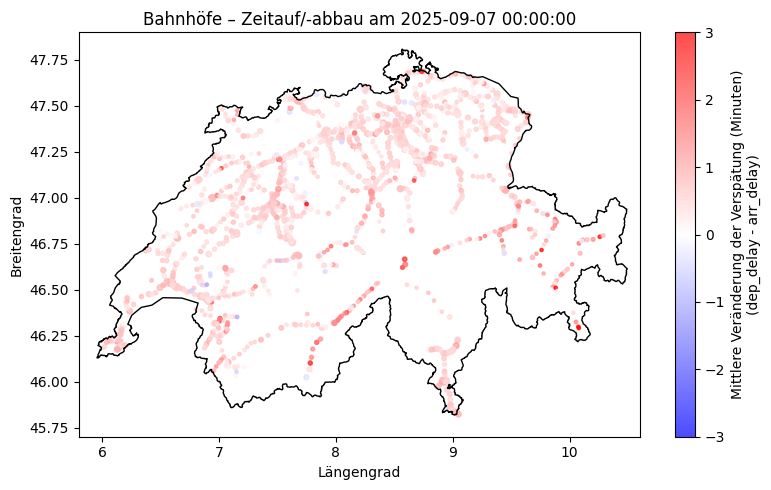

Plot für 2025-09-08 00:00:00
Geometry type: MultiPolygon


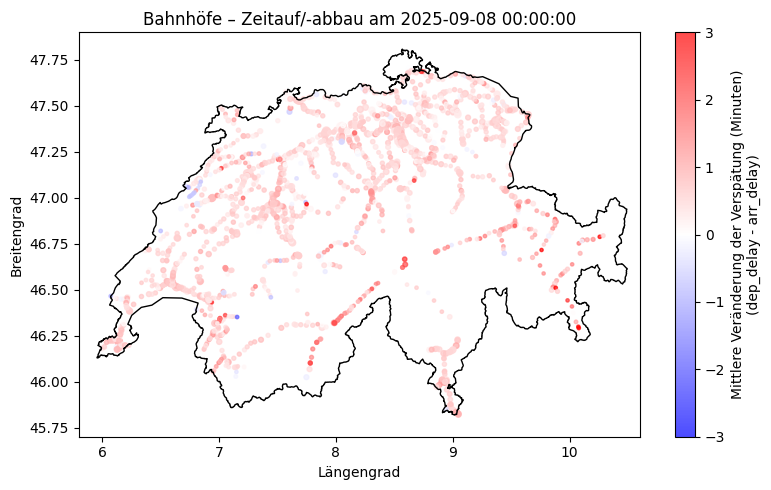

Plot für 2025-09-09 00:00:00
Geometry type: MultiPolygon


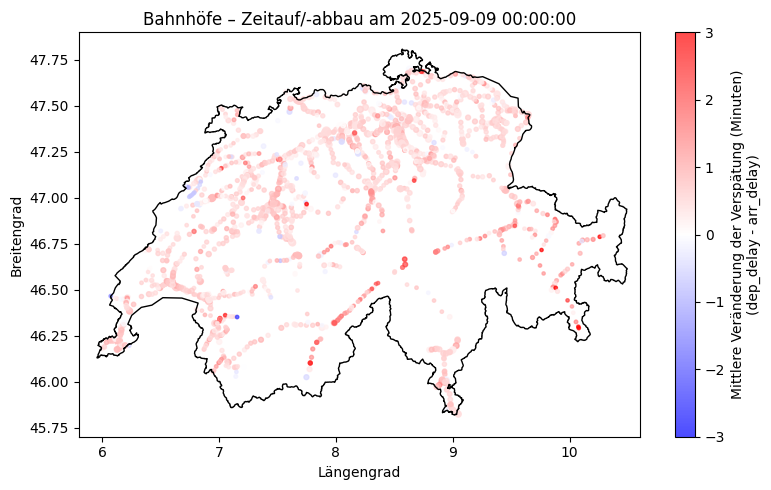

Plot für 2025-09-10 00:00:00
Geometry type: MultiPolygon


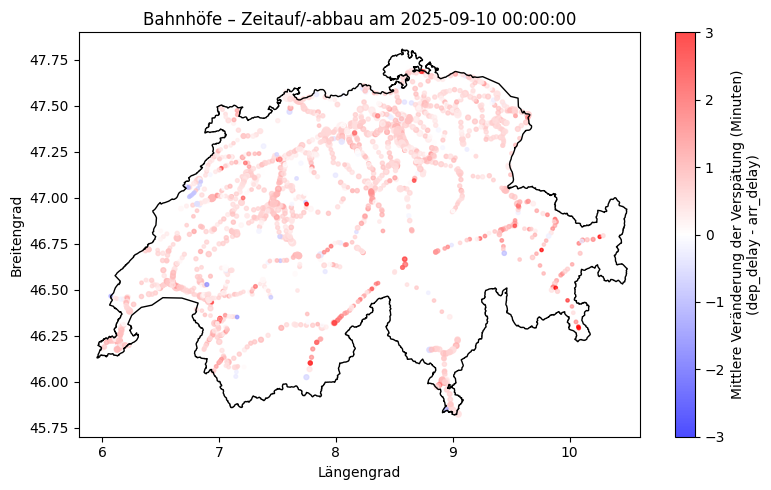

Plot für 2025-09-11 00:00:00
Geometry type: MultiPolygon


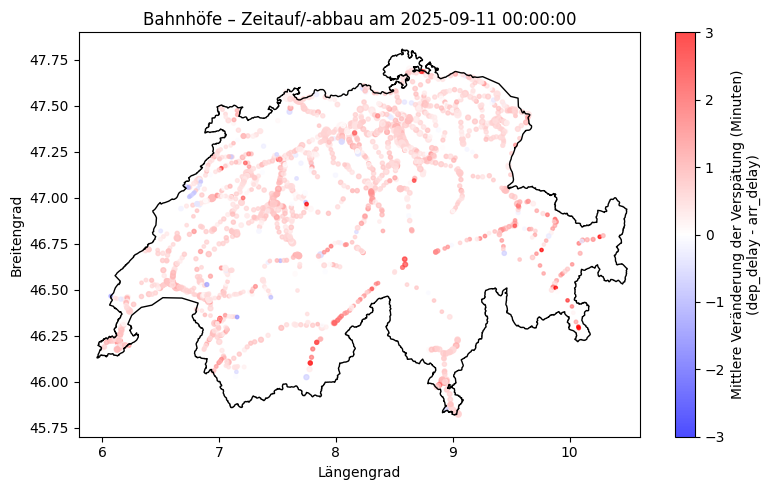

Plot für 2025-09-12 00:00:00
Geometry type: MultiPolygon


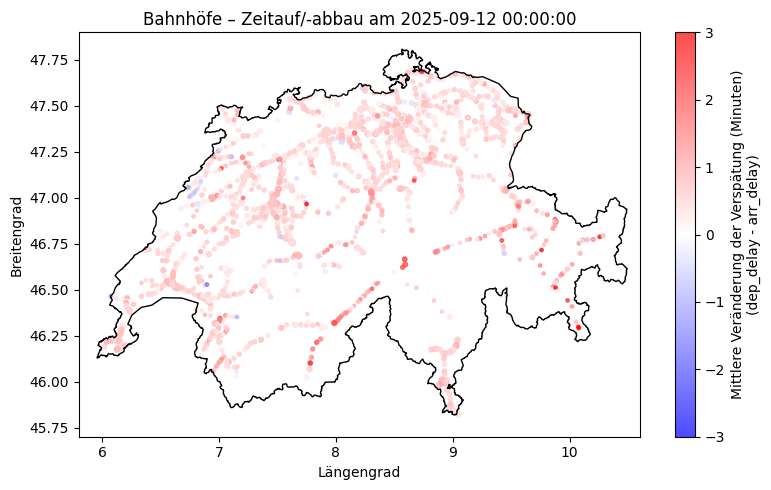

Plot für 2025-09-13 00:00:00
Geometry type: MultiPolygon


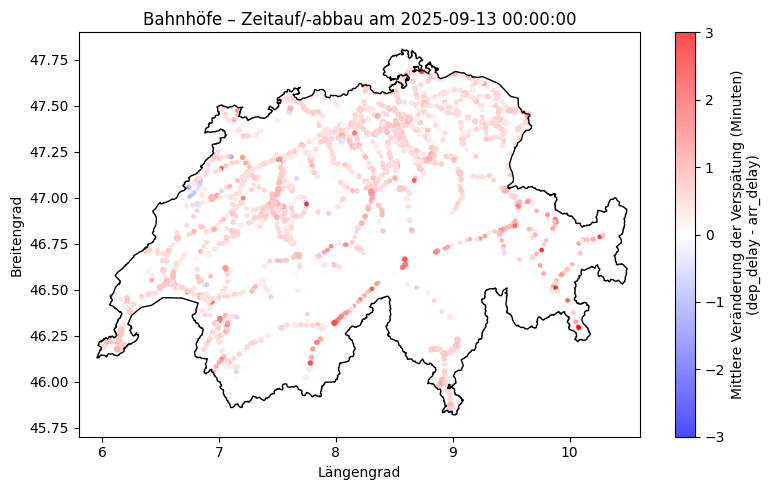

Plot für 2025-09-14 00:00:00
Geometry type: MultiPolygon


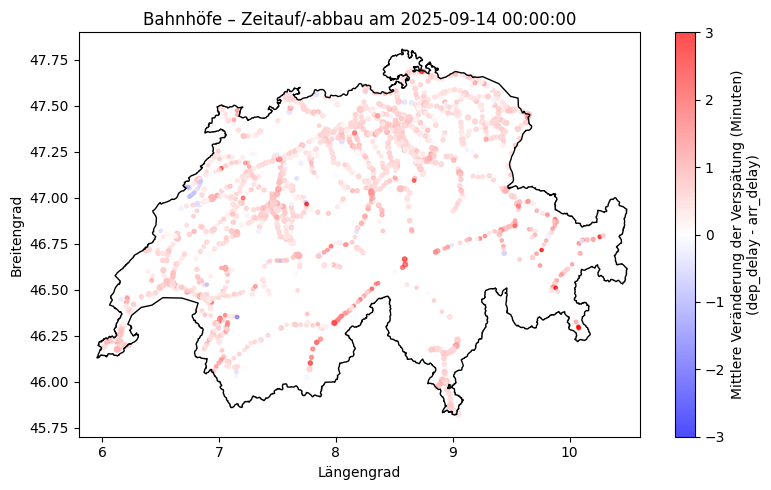

Plot für 2025-09-15 00:00:00
Geometry type: MultiPolygon


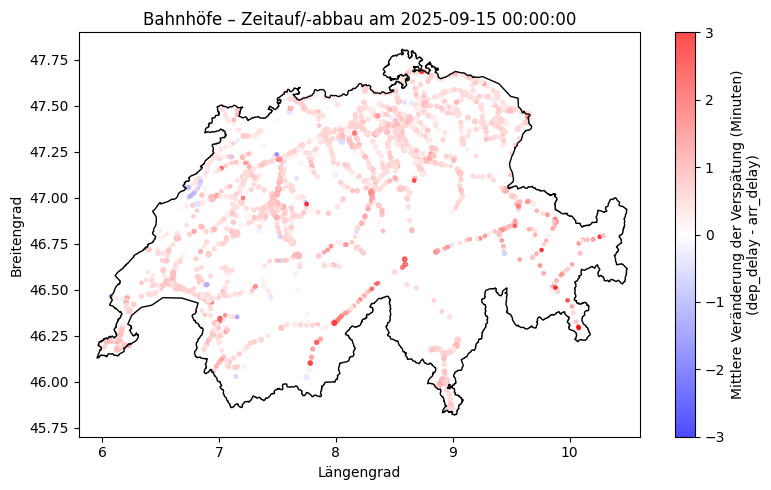

Plot für 2025-09-16 00:00:00
Geometry type: MultiPolygon


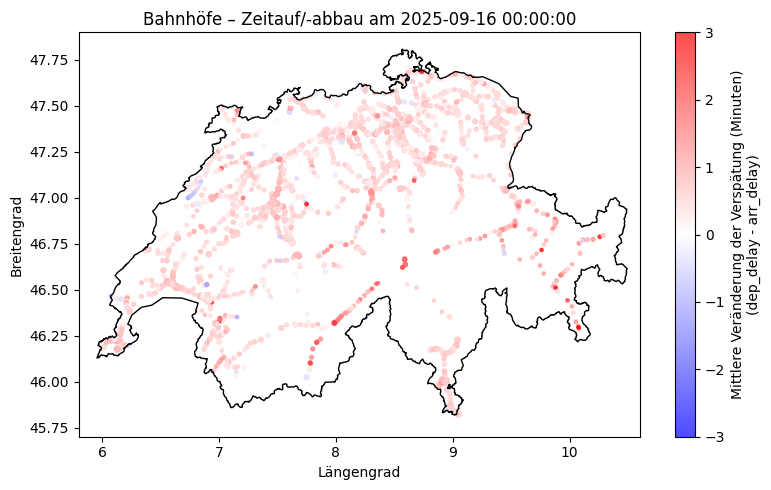

Plot für 2025-09-17 00:00:00
Geometry type: MultiPolygon


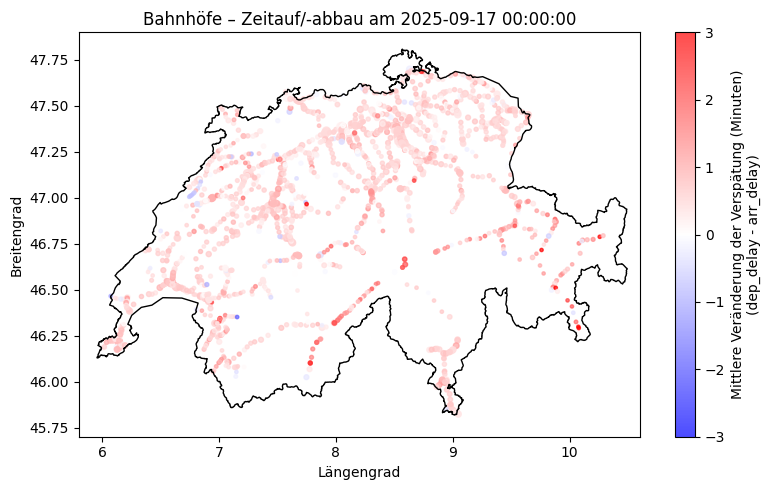

Plot für 2025-09-18 00:00:00
Geometry type: MultiPolygon


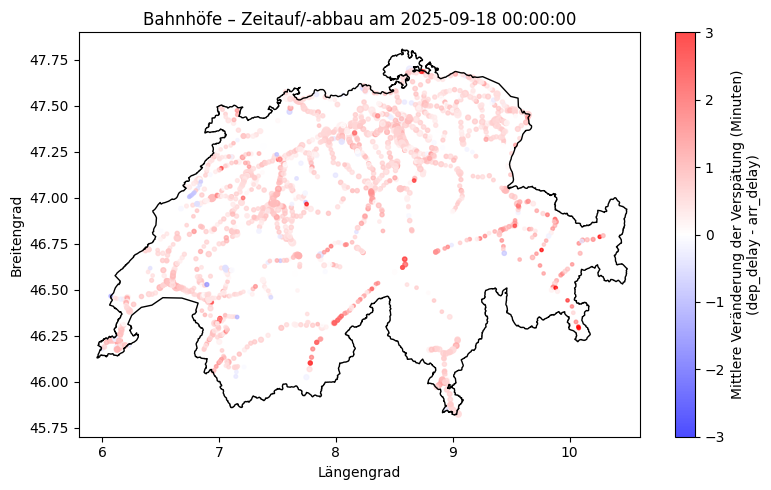

Plot für 2025-09-19 00:00:00
Geometry type: MultiPolygon


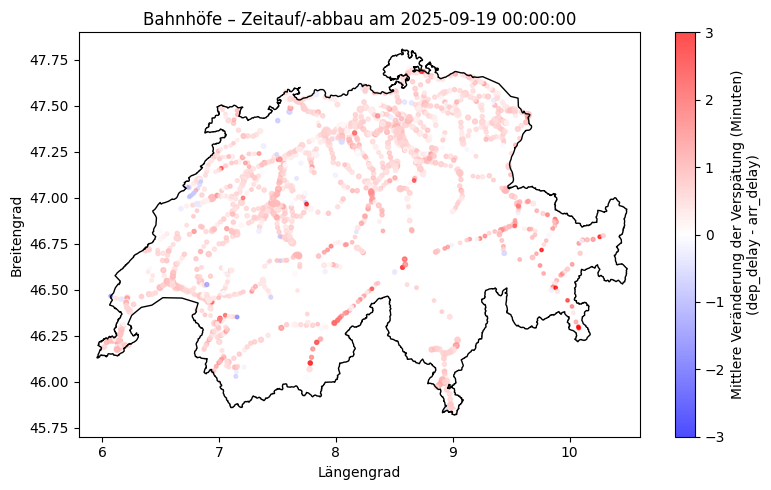

Plot für 2025-09-20 00:00:00
Geometry type: MultiPolygon


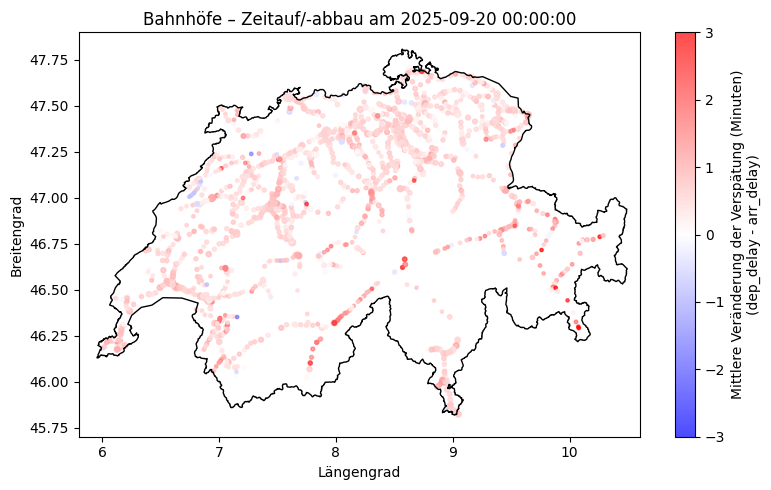

Plot für 2025-09-21 00:00:00
Geometry type: MultiPolygon


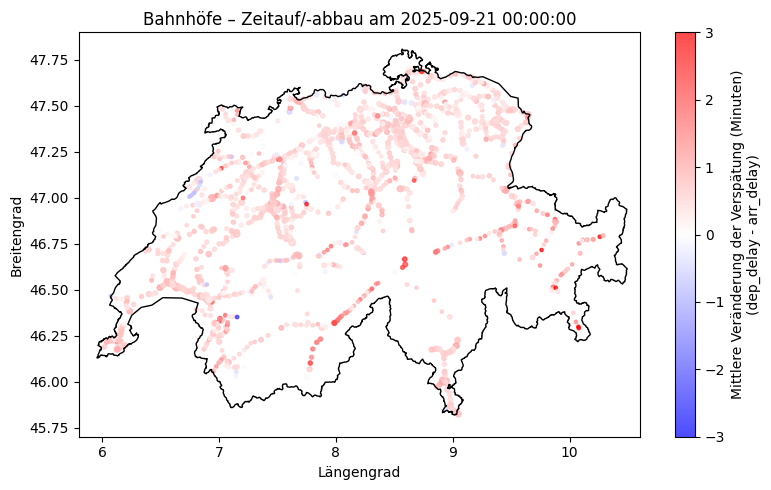

Plot für 2025-09-22 00:00:00
Geometry type: MultiPolygon


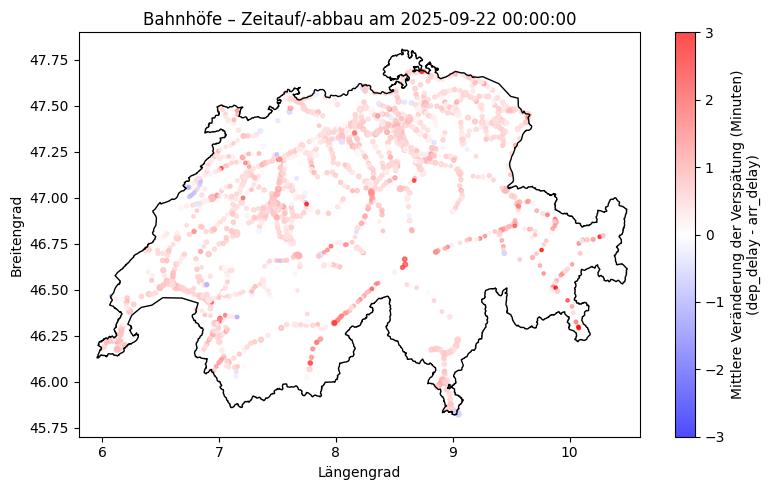

Plot für 2025-09-23 00:00:00
Geometry type: MultiPolygon


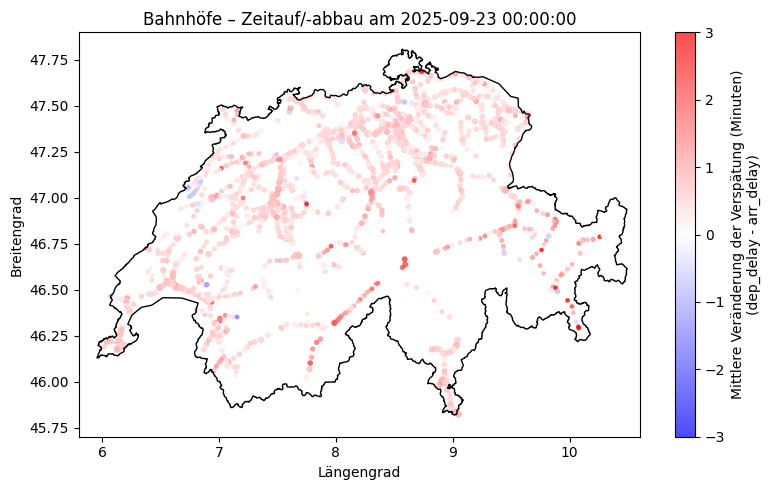

Plot für 2025-09-24 00:00:00
Geometry type: MultiPolygon


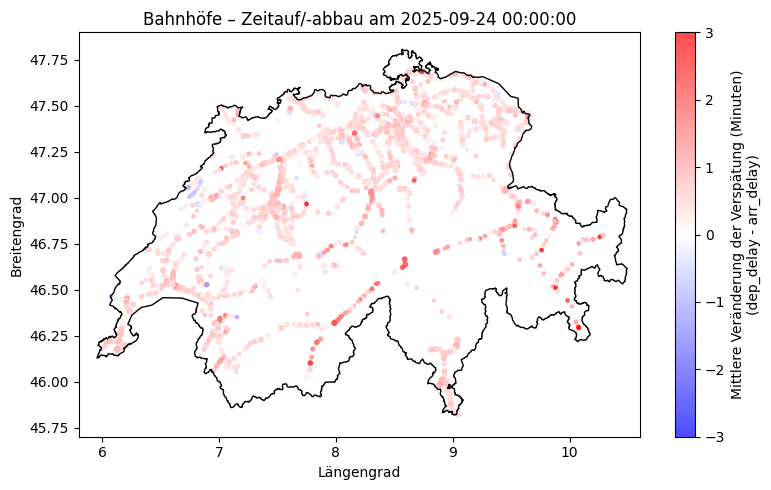

Plot für 2025-09-25 00:00:00
Geometry type: MultiPolygon


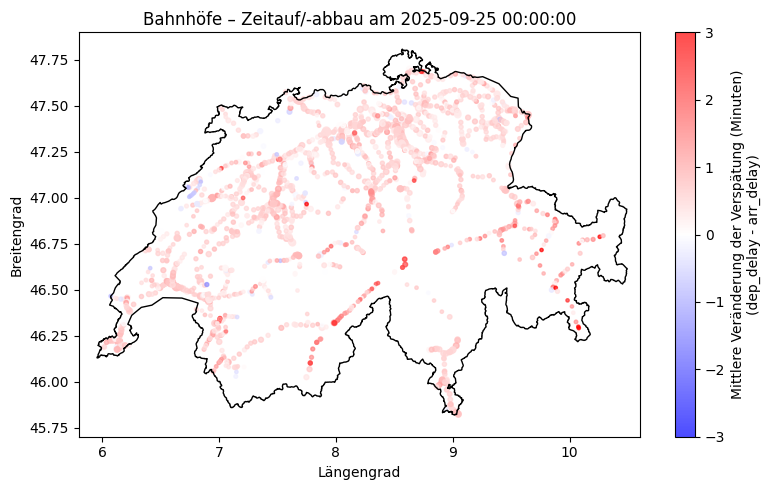

Plot für 2025-09-26 00:00:00
Geometry type: MultiPolygon


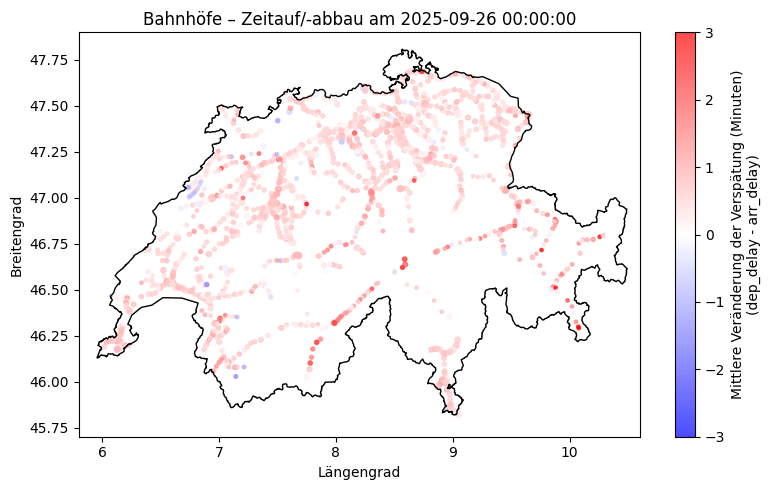

Plot für 2025-09-27 00:00:00
Geometry type: MultiPolygon


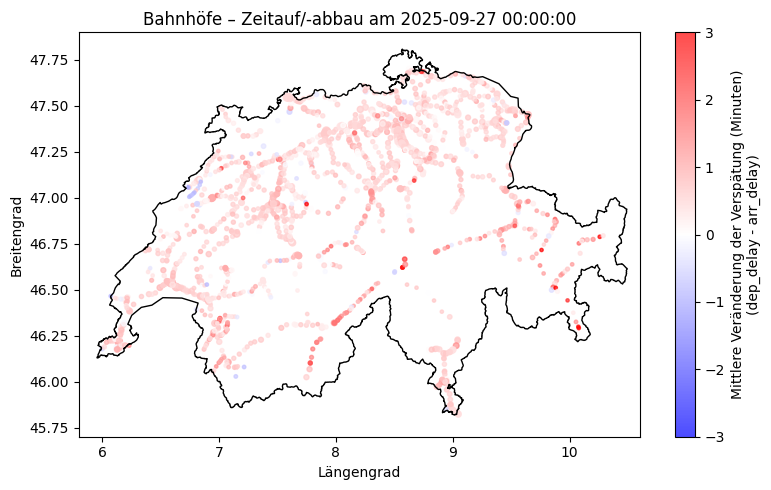

Plot für 2025-09-28 00:00:00
Geometry type: MultiPolygon


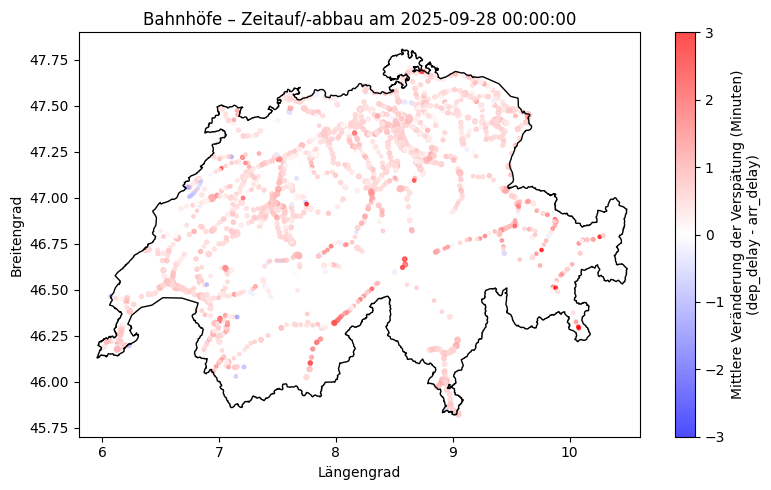

Plot für 2025-09-29 00:00:00
Geometry type: MultiPolygon


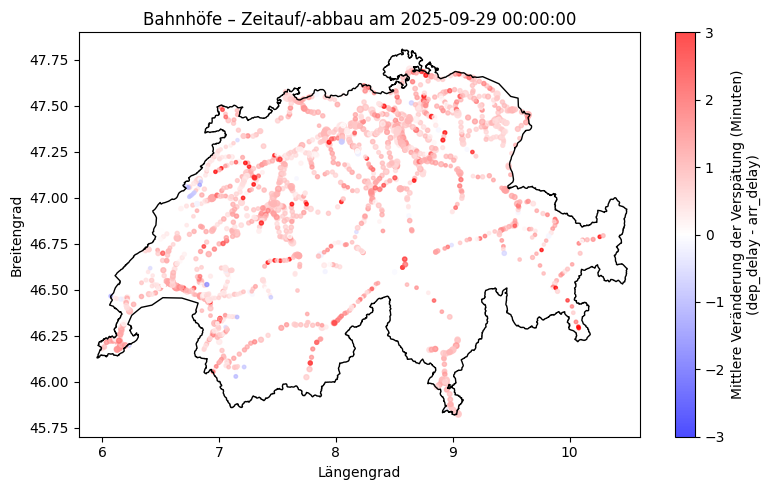

Plot für 2025-09-30 00:00:00
Geometry type: MultiPolygon


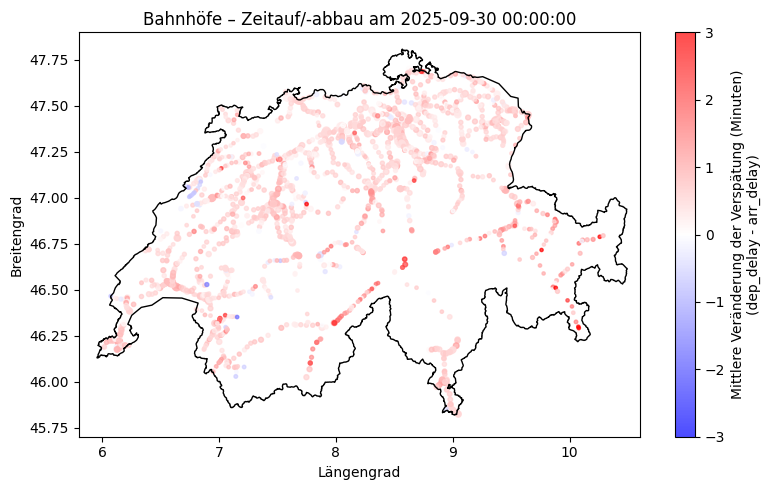

In [50]:

unique_days = sorted(df_trains["BETRIEBSTAG"].unique())

for day_str in unique_days:
    print("Plot für", day_str)

    plot_delay_map_for_day(
        day_str,
        df_trains,
        stops_small,
        min_obs=30,
        max_abs_min=3.0,
    )